# **Sales Forecasting**


Problem Statement: With the (partial) sales data from 2020, our business stakeholders wish to know what is the expected turnover they can expect in the first 3 months in 2021. With the provided dataset, you are tasked to create a model to forecast both the offline and online turnover generated in Decathlon Singapore from January 2021 to March 2021.

#### **0. Overview**

##### Problem Analysis
- This is a predictive problem involving a **continuous time series** data, where we aim to **forecast future values** based on the historical observations recorded at regular intervals over time.

##### Project Objective
- Create a model that is able to **accurately predict turnover** for **both online and offline**, to provide business insights.

##### Success Metric
- Model with the least **root mean squared error** and is able to capture the **seasonality trends**.

##### Data Analysis
- There seems to be a very strong recurring turnover pattern every week
- As this is a forecasting problem, there will be no other available data other than the dates from Jan-Mar 2021.
- Only Q3 and Q4 data is available hence there will not be any Q1 reference to capture yearly seasonality effect.

##### Feature Engineering
- There will be two main types of features: **date features** and **aggregated features**.
- For **date features**, I have broken each of them down into Quarter, Month of Quarter, Month, Week of Month, Day of Week, Day and if it is a weekend.
    - By breaking down the date into such a small granular level, it helps to serve as reference points.
    - This is the only 100% accurate data that can be derived from Jan-Mar 2021.
- For **aggregated features**, there will be 3 main aggregations: Num of Customer per day, Total Value per day and Volume (Number of Transactions) per day.
    - To capture the repeated pattern over each week, a ratio of the aggregation and the rolling average of 2,5 and 7 days before that day is taken.
        - {Agg/Rolling Average of n days where n = 2,5,7}
- In addition, whether the transaction was **online or offline** will also be taken into account.

##### Features for Forecasting

- The **dates features** can be generated at the same granular level for Jan-Mar 2021.
- The **aggregation features** will be taken from the average of the same month of quarter and day.
    - For example, for 1st January, it will be the mean aggregation of 1st July and 1st October as both are 1st Month of Quarter and 1st day.
    - While unable to capture the yearly season data, where we would usually reference to the old Q1, this is done to capture the quarterly season data.
- However, I will be testing if the model is able to predict better with or without these additional aggregation features.

##### Methodology

- Data processing and cleaning will be done to create the features as mentioned above.
- 2020 data will be split 80%/20% to form training data and validation data respectively.
- 2021 data will be testing data.
- Validation and Testing data will be split into Online and Offline data to measure for the ability to forecast both types of data.
- Data for hyperparameter tuning will be done: Scaling and Feature Selection.

##### Hyperparameter Tuning
- For this problem, I will be using a greedy approach, where I will select the better of the two hyperparameters and fix it for the rest of the tuning. 
- **Step 1: Date and Aggregated features vs Date features only**
    - This is done to see if the mean of the same month of quarter and day for the aggregation data is beneficial for Forecasting.
- **Step 2: Different Machine Learning Models**
    - For this problem, I will be utilising simple models such as Elastic Net and XGBoost to complex models such as Long Short Term Memory (LSTM).
- **Step 3: Hyperparameter Tuning**
    - Scaled aggregated data vs Non-scaled aggregated data
    - Model parameter tuning
    - Feature selection of top 5,10,15 features using XGBoost

##### Best Model
The best model ultimately was XGBoost with the following features and parameters:
- Both aggregated and date features.
- Non-Scaled data.
- Max Depth = 5 and Subsample = 1.
- No feature selection required.

#### **1. Importing libraries and Initial Data Exploration**

In [5]:
# pip install pandas
# pip install numpy
# pip install matplotlib
# pip install scikit-learn
# pip install xgboost
# pip install tensorflow
# pip install networkx

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import ElasticNet
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from keras import backend as K

In [7]:
#Import the data
df = pd.read_csv("Recruitment_Transactions_ToBeDistributed.csv")

In [ ]:
#Sensing of data frame structure and how they are organised
df.head(10)

,Unnamed: 0,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,1,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,2,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,3,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,4,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,5,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
5,6,7-1034-1034-20200712110938-102-7275,2020-07-12 11:09:38,0,NaN,NaN,City Square SG,VP6PDPPUUX,offline,0,0.0
6,7,7-1034-1034-20200727192152-102-9163,2020-07-27 19:21:52,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
7,8,7-1034-1034-20200724113113-102-8745,2020-07-24 11:31:13,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
8,9,7-1034-1034-20200704124211-210-5627,2020-07-04 12:42:11,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
9,10,7-1034-1034-20200712105212-102-7270,2020-07-12 10:52:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0


In [ ]:
#Sensing of the variety of data available
df.sample(10)

,Unnamed: 0,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
4790241,4790242,7-1034-1034-20200805205018-214-5413,2020-08-05 20:50:18,1366225,BLANKET,MOUNTAIN,City Square SG,NaN,offline,3,52.0
268737,268738,7-969-969-20200708191257-210-2415,2020-07-08 19:12:57,7208097,ANKLE BRACE SUP,NETBALL,Bedok SG,UR8V2B11UZ,offline,5,25.0
4072983,4072984,7-1979-1979-20201103192648-203-7593,2020-11-03 19:26:48,7362099,SWIMSUIT,SWIMMING,Decathlon Holland Village,0DQMPLGLPT,offline,3,42.0
2048910,2048911,7-969-969-20201126151603-203-3796,2020-11-26 15:16:03,7421397,T-SHIRT,PILATES,Bedok SG,NaN,offline,2,18.0
459058,459059,7-2128-2128-20201221153225-220-6433,2020-12-21 15:32:25,7358962,LEGGINGS,SURFING,Website,CPI8UHD9OS,online,3,37.5
1820567,1820568,7-1979-1979-20201124123415-101-9474,2020-11-24 12:34:15,7216004,WEIGHTED BALL,PILATES,Decathlon Holland Village,5BGNA211O5,offline,4,37.0
1464540,1464541,7-2459-2459-20201229153022-203-1084,2020-12-29 15:30:22,2436452,T-SHIRT,HUNTING,Centre Point,NaN,offline,4,24.5
3030760,3030761,7-2128-2128-20201009131032-220-2694,2020-10-09 13:10:32,6980994,T-SHIRT,RUNNING,Website,UJ0476KKCC,online,2,10.5
3256859,3256860,7-969-969-20201004152832-206-5357,2020-10-04 15:28:32,7210677,SHORTS,RUNNING,Bedok SG,NZ6MNAZKT9,offline,2,25.0
3733272,3733273,7-1034-1034-20200805150123-211-6259,2020-08-05 15:01:23,7321963,SHOES,TENNIS,City Square SG,7WTQJ578NW,offline,3,31.5


In [ ]:
#Understanding the object types
df.dtypes

Unnamed: 0                  int64
the_transaction_id         object
the_date_transaction       object
sku_idr_sku                 int64
product_type               object
sports                     object
but_name_business_unit     object
ctm_customer_id            object
the_to_type                object
f_qty_item                  int64
f_to_tax_in               float64
dtype: object

In [ ]:
#Number of transactions with 0 items
df[df["f_qty_item"]==0]

,Unnamed: 0,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,1,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,2,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,3,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,4,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,5,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
3722056,3722057,7-969-969-20201215111658-102-466,2020-12-15 11:16:58,7204242,UNDEFINED,WORKSHOP AND SERVICES,Bedok SG,YFIJRLKU4L,offline,0,0.0
3722066,3722067,7-969-969-20201218220951-101-3168,2020-12-18 22:09:51,7238111,UNDEFINED,WORKSHOP AND SERVICES,Bedok SG,NaN,offline,0,0.0
3722071,3722072,7-969-969-20201210111617-102-232,2020-12-10 11:16:17,7204242,UNDEFINED,WORKSHOP AND SERVICES,Bedok SG,0421DL3FI1,offline,0,0.0
3722073,3722074,7-969-969-20201210111617-102-232,2020-12-10 11:16:17,7204242,UNDEFINED,WORKSHOP AND SERVICES,Bedok SG,0421DL3FI1,offline,0,0.0


In [ ]:
#Number of transactions with 0 turnover
df[df["f_to_tax_in"]==0] 

,Unnamed: 0,the_transaction_id,the_date_transaction,sku_idr_sku,product_type,sports,but_name_business_unit,ctm_customer_id,the_to_type,f_qty_item,f_to_tax_in
0,1,7-1034-1034-20200708214026-101-8628,2020-07-08 21:40:26,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
1,2,7-1034-1034-20200708164857-211-1734,2020-07-08 16:48:57,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
2,3,7-1034-1034-20200701155410-102-6163,2020-07-01 15:54:10,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
3,4,7-1034-1034-20200713202706-102-7516,2020-07-13 20:27:06,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
4,5,7-1034-1034-20200727160812-211-4800,2020-07-27 16:08:12,0,NaN,NaN,City Square SG,NaN,offline,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
4700134,4700135,7-1871-1871-20200728201226-212-9330,2020-07-28 20:12:26,942687,BIKE LIGHT,CYCLING,Joo Koon,K0XZCPR58D,offline,4,0.0
4716977,4716978,7-1979-1979-20200913124602-101-6723,2020-09-13 12:46:02,379525,BELL,CYCLING,Decathlon Holland Village,EW34EC1X35,offline,1,0.0
4751256,4751257,7-2459-2459-20201101102623-102-4537,2020-11-01 10:26:23,942687,BIKE LIGHT,CYCLING,Centre Point,E0YRVOMTHU,offline,3,0.0
4751952,4751953,7-2459-2459-20201002125132-101-958,2020-10-02 12:51:32,7317793,BIKE LIGHT,CYCLING,Centre Point,NaN,offline,4,0.0


In [ ]:
#Filter out all transaction rows with 0 items

filtered_df = df[df["f_qty_item"] != 0]
filtered_df = filtered_df[filtered_df["f_to_tax_in"] != 0]

print(f"Number of total rows: {len(df)}")
print(f"Number of filtered rows: {len(filtered_df)}")

Number of total rows: 5496751
Number of filtered rows: 5462787


##### Conclusion for initial data exploration

Generally, data looks cleaned. Objects are of the right format, however, realised that there are 30,013 and 5151 records with 0 quantity and 0 turnover respectively.

#### **2. Data Preparation:**

In this segment, the focus will be:
- Aggregation of Number of Customers, Value and Transactions for each day from July'2020 to December'2020.
- Creating the granular levels of dates for 2020 and 2021.
- Find the mean of same month of quarter and day to get aggregated data for 2021.
- Final data for 2020 and 2021 will be stored in turnover_2020_df and turnover_2021_df

In [ ]:
#Sort the data from earliest to latest as ordering in timer series is crucial
turnover_df = filtered_df.sort_values(by='the_date_transaction')

#Aggregation of number of customers, number of transaction and total sales
turnover_df = turnover_df.loc[:, ['the_date_transaction', 'f_to_tax_in', 'the_to_type', 'ctm_customer_id',"the_transaction_id"]]

turnover_df['the_date_transaction'] = pd.to_datetime(turnover_df['the_date_transaction'])
turnover_df['transaction_month_of_quarter'] = ((turnover_df['the_date_transaction'].dt.month - 1) % 3) + 1
turnover_df['transaction_month'] = turnover_df['the_date_transaction'].dt.month
turnover_df['transaction_day'] = turnover_df['the_date_transaction'].dt.day

turnover_df = turnover_df.drop("the_date_transaction", axis=1)

turnover_data = pd.DataFrame(turnover_df.groupby([
    "transaction_month",
    "transaction_month_of_quarter",
    "transaction_day",
    "the_to_type"
]).agg(
    customer_count=("ctm_customer_id", "nunique"),
    volume=("the_transaction_id", "nunique"),
    total_turnover=("f_to_tax_in", "sum")
).reset_index())

#Prepare the date features
dates_2020 = pd.date_range(start='2021-07-01', end='2021-12-31', freq='D')
data_2020 = pd.DataFrame({'the_date_transaction': dates_2020})
data_2020['the_date_transaction'] = pd.to_datetime(data_2020['the_date_transaction'])
data_2020['transaction_quarter'] = data_2020['the_date_transaction'].dt.quarter
data_2020['transaction_month_of_quarter'] = ((data_2020['the_date_transaction'].dt.month - 1) % 3) + 1
data_2020['transaction_month'] = data_2020['the_date_transaction'].dt.month
data_2020['transaction_week_of_month'] = (data_2020['the_date_transaction'].dt.day - 1) // 7 + 1
data_2020['transaction_day_of_week'] = data_2020['the_date_transaction'].dt.dayofweek
data_2020['transaction_day'] = data_2020['the_date_transaction'].dt.day
data_2020['weekend_category'] = data_2020['transaction_day_of_week'].apply(lambda x: 1 if x in [6,0] else 0)

#Left Join both the features df to get turnover_2020_df
turnover_2020_df = data_2020.merge(turnover_data, on=[
    "transaction_month",
    "transaction_month_of_quarter",
    "transaction_day"
],how="left")
turnover_2020_df = turnover_2020_df.drop('the_date_transaction',axis=1)
turnover_2020_df["the_to_type"] = turnover_2020_df["the_to_type"].map({"online": 1, "offline": 0})

turnover_2020_df.head(10)

,transaction_quarter,transaction_month_of_quarter,transaction_month,transaction_week_of_month,transaction_day_of_week,transaction_day,weekend_category,the_to_type,customer_count,volume,total_turnover
0,3,1,7,1,3,1,0,0,2573,5381,1276576.80
1,3,1,7,1,3,1,0,1,628,698,161534.10
2,3,1,7,1,4,2,0,0,2671,5516,1334812.80
3,3,1,7,1,4,2,0,1,717,782,173720.90
4,3,1,7,1,5,3,0,0,3297,6652,1609395.10
5,3,1,7,1,5,3,0,1,652,697,149911.90
6,3,1,7,1,6,4,1,0,4831,9631,2715392.02
7,3,1,7,1,6,4,1,1,783,859,177307.60
8,3,1,7,1,0,5,1,0,4146,8466,2317331.25
9,3,1,7,1,0,5,1,1,820,913,184053.90


In [ ]:
#Preparing the date features for 2021
dates_2021 = pd.date_range(start='2021-01-01', end='2021-03-31', freq='D')
data_2021 = pd.DataFrame({'the_date_transaction': dates_2021})
data_2021['the_date_transaction'] = pd.to_datetime(data_2021['the_date_transaction'])
data_2021['transaction_quarter'] = data_2021['the_date_transaction'].dt.quarter
data_2021['transaction_month_of_quarter'] = ((data_2021['the_date_transaction'].dt.month - 1) % 3) + 1
data_2021['transaction_month'] = data_2021['the_date_transaction'].dt.month
data_2021['transaction_week_of_month'] = (data_2021['the_date_transaction'].dt.day - 1) // 7 + 1
data_2021['transaction_day_of_week'] = data_2021['the_date_transaction'].dt.dayofweek
data_2021['transaction_day'] = data_2021['the_date_transaction'].dt.day
data_2021['weekend_category'] = data_2021['transaction_day_of_week'].apply(lambda x: 1 if x in [6,0] else 0)

#Find the mean of delta 30 and 60 days which are the days with the same month of quarter and day
delta_30_60 = turnover_2020_df.groupby(['transaction_month_of_quarter', 'transaction_day',"the_to_type"]).mean()
delta_30_60 = delta_30_60.reset_index()
delta_30_60 = delta_30_60.drop(["transaction_month", "transaction_quarter", "transaction_week_of_month", "transaction_day_of_week", "weekend_category"],axis=1)

#Left join the two features df to get turnover_2021_df
turnover_2021_df = data_2021.merge(delta_30_60, on=['transaction_month_of_quarter', 'transaction_day'],how="left")
turnover_2021_df = turnover_2021_df.drop('the_date_transaction',axis=1)

turnover_2021_df

,transaction_quarter,transaction_month_of_quarter,transaction_month,transaction_week_of_month,transaction_day_of_week,transaction_day,weekend_category,the_to_type,customer_count,volume,total_turnover
0,1,1,1,1,4,1,0,0,2676.5,5546.5,1177720.750
1,1,1,1,1,4,1,0,1,667.0,742.0,158213.200
2,1,1,1,1,5,2,0,0,3201.0,6566.5,1429534.550
3,1,1,1,1,5,2,0,1,792.0,866.5,175024.705
4,1,1,1,1,6,3,1,0,4633.0,9377.0,2163204.225
...,...,...,...,...,...,...,...,...,...,...,...
175,1,3,3,5,0,29,1,1,957.5,1071.5,202728.890
176,1,3,3,5,1,30,0,0,3653.0,7617.5,1587780.750
177,1,3,3,5,1,30,0,1,951.5,1027.0,201543.145
178,1,3,3,5,2,31,0,0,4636.0,9443.0,2114278.400


#### **3. Feature Preparation**

In this segment, the focus will be:
- Define the function get_rolling_average() which takes in a dataframe and outputs the ratio of 2,5 and 7 days.
    - This is calculated by taking the aggregated value divided by rolling average of n days before.
- This turns both turnover_df into train_val for 2020 data and online_test and offline_test for 2021 data.
    - As the requirement is to have only a single model to predict both online and offline data, the training data needs to contain both.

In [ ]:
def get_rolling_avg(t_df):
    horizons = [2, 5, 7]

    with pd.option_context('mode.chained_assignment', None):
        for horizon in horizons:
            # Calculates the rolling average of 2, 5, and 7 days
            rolling_averages = t_df.rolling(horizon).mean()

            cus_count_column = f"customer_count_ratio_{horizon}"
            t_df.loc[:, cus_count_column] = t_df["customer_count"] / rolling_averages["customer_count"]

            volume_column = f"volume_ratio_{horizon}"
            t_df.loc[:, volume_column] = t_df["volume"] / rolling_averages["volume"]

            turnover_column = f"turnover_ratio_{horizon}"
            t_df.loc[:, turnover_column] = t_df["total_turnover"] / rolling_averages["total_turnover"]

            t_df.dropna(inplace=True)

    return t_df


In [ ]:
#Split 2020 and 2021 data into online and offline as ordering matter in rolling average function, and each value should be in referenced to the same "the_to_type"
online_train_val = turnover_2020_df[turnover_2020_df["the_to_type"]==1]
offline_train_val = turnover_2020_df[turnover_2020_df["the_to_type"]==0]
online_test = turnover_2021_df[turnover_2021_df["the_to_type"]==1]
offline_test = turnover_2021_df[turnover_2021_df["the_to_type"]==0]

#Append ratio columns for both 2020 and 2021 data
online_train_val = get_rolling_avg(online_train_val)
offline_train_val = get_rolling_avg(offline_train_val)
online_test = get_rolling_avg(online_test)
offline_test = get_rolling_avg(offline_test)

#Combine the 2020 data back together and sort them from earliest to latest, as we are only training 1 model for both online and offline data, so training data needs to include both.
train_val = pd.concat([online_train_val, offline_train_val], ignore_index=True)
train_val = train_val.sort_values(by=["transaction_quarter", "transaction_month","transaction_day"]).reset_index(drop=True)

train_val

,transaction_quarter,transaction_month_of_quarter,transaction_month,transaction_week_of_month,transaction_day_of_week,transaction_day,weekend_category,the_to_type,customer_count,volume,total_turnover,customer_count_ratio_2,volume_ratio_2,turnover_ratio_2,customer_count_ratio_5,volume_ratio_5,turnover_ratio_5,customer_count_ratio_7,volume_ratio_7,turnover_ratio_7
0,3,1,7,2,0,12,1,1,679,739,163822.80,1.034273,1.032844,1.040880,1.106584,1.106950,1.161994,1.087394,1.089282,1.159230
1,3,1,7,2,0,12,1,0,4050,8275,2234248.80,0.982414,1.004369,1.015225,1.182137,1.191024,1.253585,1.250055,1.261543,1.367489
2,3,1,7,2,1,13,0,1,596,650,136007.10,0.934902,0.935925,0.907228,0.972268,0.973345,0.964546,0.982109,0.983359,0.983752
3,3,1,7,2,1,13,0,0,2279,4694,1042744.30,0.720177,0.723880,0.636403,0.669035,0.678873,0.587869,0.729180,0.738233,0.661227
4,3,1,7,2,2,14,0,1,523,557,119136.60,0.934763,0.922949,0.933878,0.875460,0.861163,0.869105,0.874373,0.857866,0.868646
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,4,3,12,5,2,29,0,0,4384,8786,1939794.70,0.973141,0.967302,0.968884,0.863468,0.840926,0.788061,0.882803,0.852430,0.822214
342,4,3,12,5,3,30,0,1,1086,1167,222200.48,0.945993,0.929880,0.916364,1.060754,1.042895,1.025762,1.017671,0.999878,0.980213
343,4,3,12,5,3,30,0,0,4586,9516,2086805.30,1.022520,1.039886,1.036510,0.924970,0.939963,0.886260,0.926224,0.927460,0.881510
344,4,3,12,5,4,31,0,1,1102,1194,212674.95,1.007313,1.011436,0.978096,1.032802,1.029843,0.964530,1.054834,1.048288,0.967673


#### **4. Preparing train, validation and test data**

In this segment, the focus will be:
- Split the train and validation data, 80% to 20%.
- Split the X and y by total_turnover.
- Print the shape of each data object.

In [ ]:
#80% of 2020 data will be used for training
train_size = int(len(train_val)*0.8)

train = train_val.iloc[:train_size]
val = train_val.iloc[train_size:]

online_val = val[val["the_to_type"]==1]
offline_val = val[val["the_to_type"]==0]

train_X = train.drop("total_turnover",axis=1)
train_y = train["total_turnover"]
online_val_X = online_val.drop("total_turnover",axis=1)
online_val_y = online_val["total_turnover"]
offline_val_X = offline_val.drop("total_turnover",axis=1)
offline_val_y = offline_val["total_turnover"]
online_test_X = online_test.drop("total_turnover",axis=1)
online_test_y = online_test["total_turnover"]
offline_test_X = offline_test.drop("total_turnover",axis=1)
offline_test_y = offline_test["total_turnover"]

print(f"train_X: {train_X.shape}")
print(f"train_y: {train_y.shape}")
print("")
print(f"online_val_X: {online_val_X.shape}")
print(f"online_val_y: {online_val_y.shape}")
print(f"offline_val_X: {offline_val_X.shape}")
print(f"offline_val_y: {offline_val_y.shape}")
print("")
print(f"online_test_X: {online_test_X.shape}")
print(f"online_test_y: {online_test_y.shape}")
print(f"offline_test_X: {offline_test_X.shape}")
print(f"offline_test_y: {offline_test_y.shape}")

train_X: (276, 19)
train_y: (276,)

online_val_X: (35, 19)
online_val_y: (35,)
offline_val_X: (35, 19)
offline_val_y: (35,)

online_test_X: (79, 19)
online_test_y: (79,)
offline_test_X: (79, 19)
offline_test_y: (79,)


#### **5. Prepare Hyperparameter Tuning Data**

In this segment, the focus will be:
- **Prepare the X data objects with only the date features.**
    - This will be used against date and aggreagated features.
- **Prepare the scaled data for the aggregation features.**
    - Date features should not be scaled.
    - This will be used against non scaled data.
- **Prepare XGBoost feature selection data.**
    - This will be used against top 5, 10, 15 and all 19 rows.

Preparing only date features

In [ ]:
#Date features column
date_columns = [
    'transaction_quarter', 'transaction_month_of_quarter', 'transaction_month',
    'transaction_week_of_month', 'transaction_day_of_week', 'transaction_day',
    'weekend_category', 'the_to_type'
]

#Select only date features column for all X datasets
date_train_X = train_X.loc[:, date_columns]
date_online_val_X = online_val_X.loc[:, date_columns]
date_offline_val_X = offline_val_X.loc[:, date_columns]
date_online_test_X = online_test_X.loc[:, date_columns]
date_offline_test_X = offline_test_X.loc[:, date_columns]

print(f"date_train_X: {date_train_X.shape}")
print(f"date_online_val_X: {date_online_val_X.shape}")
print(f"date_offline_val_X: {date_offline_val_X.shape}")
print(f"date_online_test_X: {date_online_test_X.shape}")
print(f"date_offline_test_X: {date_offline_test_X.shape}")

date_train_X: (276, 8)
date_online_val_X: (35, 8)
date_offline_val_X: (35, 8)
date_online_test_X: (79, 8)
date_offline_test_X: (79, 8)


Preparing scaled data

In [ ]:
#Function to only scale aggregated columns
def min_max_scale_columns(df, columns):
    scaler = MinMaxScaler()

    df[columns] = scaler.fit_transform(df[columns])

    return df

#Aggregated feature columns
columns_scale = ['customer_count', 'volume', 'customer_count_ratio_2', 'volume_ratio_2', 'turnover_ratio_2',
                    'customer_count_ratio_5', 'volume_ratio_5', 'turnover_ratio_5',
                    'customer_count_ratio_7', 'volume_ratio_7', 'turnover_ratio_7']

#Scale all the X datasets
scaled_train_X = min_max_scale_columns(train_X.copy(), columns_scale)
scaled_online_val_X = min_max_scale_columns(online_val_X.copy(), columns_scale)
scaled_offline_val_X = min_max_scale_columns(offline_val_X.copy(), columns_scale)
scaled_online_test_X = min_max_scale_columns(online_test_X.copy(), columns_scale)
scaled_offline_test_X = min_max_scale_columns(offline_test_X.copy(), columns_scale)

scaled_train_X 


,transaction_quarter,transaction_month_of_quarter,transaction_month,transaction_week_of_month,transaction_day_of_week,transaction_day,weekend_category,the_to_type,customer_count,volume,customer_count_ratio_2,volume_ratio_2,turnover_ratio_2,customer_count_ratio_5,volume_ratio_5,turnover_ratio_5,customer_count_ratio_7,volume_ratio_7,turnover_ratio_7
0,3,1,7,2,0,12,1,1,0.029714,0.016319,0.464822,0.452367,0.459044,0.455884,0.445604,0.442603,0.398561,0.395007,0.402128
1,3,1,7,2,0,12,1,0,0.648019,0.663575,0.401048,0.417545,0.432908,0.526414,0.523953,0.508460,0.535130,0.537137,0.534296
2,3,1,7,2,1,13,0,1,0.014490,0.008675,0.342621,0.333842,0.322885,0.330497,0.321098,0.300632,0.310164,0.307611,0.290764
3,3,1,7,2,1,13,0,0,0.323184,0.356008,0.078564,0.074525,0.046979,0.047424,0.046679,0.029790,0.097806,0.105361,0.086078
4,3,1,7,2,2,14,0,1,0.001101,0.000687,0.342451,0.317973,0.350035,0.240126,0.216555,0.232007,0.219709,0.204069,0.217713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271,4,2,11,4,2,24,0,0,0.438188,0.481577,0.424795,0.430857,0.427366,0.109619,0.119408,0.105854,0.161961,0.176245,0.160021
272,4,2,11,4,3,25,0,1,0.094277,0.056515,0.517765,0.527509,0.563538,0.222118,0.254823,0.270162,0.235047,0.277600,0.272930
273,4,2,11,4,3,25,0,0,0.438371,0.471099,0.422887,0.399962,0.419026,0.141815,0.136279,0.126332,0.157881,0.160318,0.155872
274,4,2,11,4,4,26,0,1,0.142333,0.075496,0.561313,0.514770,0.599544,0.474845,0.456621,0.559147,0.390038,0.382899,0.477722


Feature Selection

In [ ]:
#Train the feature selection
dmatrix = xgb.DMatrix(train_X, label=train_y)
model = xgb.train({'objective': 'reg:squarederror', }, dmatrix)

#Sort the features from most important to least
importance = model.get_score(importance_type='gain')
importance_sorted = sorted(importance.items(), key=lambda x: x[1], reverse=True)

#Print all features and their importance score
for feature, score in importance_sorted:
    print(f"Feature: {feature}, Score: {score}")

#Append top n features into respective list
top5_cols = []
top10_cols = []
top15_cols = []

for i, (feature, score) in enumerate(importance_sorted):
    if i < 5:
        top5_cols.append(feature)
    if i < 10:
        top10_cols.append(feature)
    if i < 15:
        top15_cols.append(feature)

print("")
print("Top 5 columns:", top5_cols)
print("Top 10 columns:", top10_cols)
print("Top 15 columns:", top15_cols)

#Select only topn_feature_columns
top5_train_X = train_X[top5_cols]
top5_online_val_X = online_val_X[top5_cols]
top5_offline_val_X = offline_val_X[top5_cols]
top5_online_test_X = online_test_X[top5_cols]
top5_offline_test_X = offline_test_X[top5_cols]

top10_train_X = train_X[top10_cols]
top10_online_val_X = online_val_X[top10_cols]
top10_offline_val_X = offline_val_X[top10_cols]
top10_online_test_X = online_test_X[top10_cols]
top10_offline_test_X = offline_test_X[top10_cols]

top15_train_X = train_X[top15_cols]
top15_online_val_X = online_val_X[top15_cols]
top15_offline_val_X = offline_val_X[top15_cols]
top15_online_test_X = online_test_X[top15_cols]
top15_offline_test_X = offline_test_X[top15_cols]

Feature: volume, Score: 9606008930304.0
Feature: customer_count_ratio_7, Score: 3457738604544.0
Feature: customer_count, Score: 1083096301568.0
Feature: the_to_type, Score: 457822273536.0
Feature: turnover_ratio_7, Score: 27553871872.0
Feature: transaction_month, Score: 13613620224.0
Feature: transaction_month_of_quarter, Score: 5576034816.0
Feature: volume_ratio_7, Score: 3881316352.0
Feature: customer_count_ratio_2, Score: 2649286656.0
Feature: transaction_quarter, Score: 2376539904.0
Feature: transaction_day, Score: 1650076032.0
Feature: volume_ratio_5, Score: 1339744256.0
Feature: volume_ratio_2, Score: 1158938624.0
Feature: customer_count_ratio_5, Score: 488234080.0
Feature: turnover_ratio_2, Score: 460682336.0
Feature: turnover_ratio_5, Score: 340895392.0
Feature: transaction_day_of_week, Score: 218796032.0
Feature: transaction_week_of_month, Score: 201061376.0

Top 5 columns: ['volume', 'customer_count_ratio_7', 'customer_count', 'the_to_type', 'turnover_ratio_7']
Top 10 columns

#### **6. Preparing the Result Metric**

In this segment, the focus will be:
- Initialising a result_df data frame to store our hyperparameters and result

In [ ]:
columns = ['model', 'scaled', 'hyperparameter1', 'hyperparameter2', 'number of features', 'rmse']
result_df = pd.DataFrame(columns=columns)

result_df

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse


#### **7. Model Building**

In this segment, the focus will be building the functions that will be able to train, predict, visualise and update result_df. Each model will also be able to tune their parameters:
- Elastic Net Model
     - Alpha: Overall regularization strength parameter. The closer to 0, the closer to ordinary linear system.
     - l1 ratio: Controls the ratio between Lasso and Ridge Regularization. The closer to 1, the closer to Lasso.
- XGBoost:
     - Max Depth: Maximum depth of a tree in the XGBoost ensemble. The higher the number of tree, the more complex it is.
     - Subsample: Fraction of samples used to train each tree. 1 means 100% is used and using less than 1 introduces overfitting.
- LSTM:
     - Dropout Rate: Probability of a node dropping out a connection. The closer to 1 means, more nodes will be dropped.

In [ ]:
def predElasticNet(trainX, trainy, online_valX, online_valy, offline_valX, offline_valy, online_testX, offline_testX, a, l1, Xsort,result_df,title):
    
    #Initialise and fitthe model
    model = ElasticNet(alpha=a, l1_ratio=l1,max_iter=5000)
    model.fit(trainX, trainy)

    #Predict online validation
    prediction1 = model.predict(online_valX)
    rmse1 = np.mean((prediction1 - online_valy) ** 2)

    #Predict offline validation
    prediction2 = model.predict(offline_valX)
    rmse2 = np.mean((prediction2 - offline_valy) ** 2)

    #Update result_df
    new_row = pd.DataFrame([['elastic net', 1 if Xsort else 0, f"alpha={a}", f"l1_ratio={l1}", trainX.shape[1], (rmse1+rmse2)/2]], columns=result_df.columns)
    result_df = pd.concat([result_df, new_row], ignore_index=True)
    
    #Predict online and offline test
    prediction3 = model.predict(online_testX)
    prediction4 = model.predict(offline_testX)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot validation on the left subplot
    axs[0].plot(online_valy.index, online_valy, label='Actual (Online)')
    axs[0].plot(online_valy.index, prediction1, label='Predicted (Online)', linestyle='--')
    axs[0].plot(offline_valy.index, offline_valy, label='Actual (Offline)')
    axs[0].plot(offline_valy.index, prediction2, label='Predicted (Offline)', linestyle='--')
    axs[0].set_ylabel('Value')
    axs[0].set_title("Validation")
    axs[0].legend()

    # Plot test predictions on the right subplot
    axs[1].plot(online_testX.index, prediction3, label='Predicted (Online)', linestyle='--')
    axs[1].plot(offline_testX.index, prediction4, label='Predicted (Offline)', linestyle='--')
    axs[1].set_ylabel('Value')
    axs[1].set_title("Forecast")
    axs[1].legend()

    fig.suptitle(title, fontsize=16)

    # Adjust layout to avoid overlapping labels and title
    plt.tight_layout()

    # Show the plot
    plt.show()

    return result_df

In [ ]:
def predXGBoost(trainX, trainy, online_valX, online_valy, offline_valX, offline_valy, online_testX, offline_testX, maxdepth, subsample, Xsort,result_df,title):
    
    #Initialise and train XGBoost model
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'eta': 0.1,
        'max_depth': maxdepth,
        'gamma': 0.25,
        'subsample': subsample
    }

    model = xgb.XGBRegressor(**params)

    model.fit(trainX, trainy)

    #Predict online validation
    prediction1 = model.predict(online_valX)
    rmse1 = np.mean((prediction1 - online_valy) ** 2)

    #Predict offline validation
    prediction2 = model.predict(offline_valX)
    rmse2 = np.mean((prediction2 - offline_valy) ** 2)

    #Update result_df
    new_row = pd.DataFrame([['XGBoost', 1 if Xsort else 0, f"max_depth={maxdepth}", f"subsample={subsample}", trainX.shape[1], (rmse1+rmse2)/2]], columns=result_df.columns)
    result_df = pd.concat([result_df, new_row], ignore_index=True)
    
    #Predict online and offline test
    prediction3 = model.predict(online_testX)
    prediction4 = model.predict(offline_testX)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot validation on the left subplot
    axs[0].plot(online_valy.index, online_valy, label='Actual (Online)')
    axs[0].plot(online_valy.index, prediction1, label='Predicted (Online)', linestyle='--')
    axs[0].plot(offline_valy.index, offline_valy, label='Actual (Offline)')
    axs[0].plot(offline_valy.index, prediction2, label='Predicted (Offline)', linestyle='--')
    axs[0].set_ylabel('Value')
    axs[0].set_title("Validation")
    axs[0].legend()

    # Plot test predictions on the right subplot
    axs[1].plot(online_testX.index, prediction3, label='Predicted (Online)', linestyle='--')
    axs[1].plot(offline_testX.index, prediction4, label='Predicted (Offline)', linestyle='--')
    axs[1].set_ylabel('Value')
    axs[1].set_title("Forecast")
    axs[1].legend()

    fig.suptitle(title, fontsize=16)

    # Adjust layout to avoid overlapping labels and title
    plt.tight_layout()

    # Show the plot
    plt.show()

    return result_df

In [ ]:
#Return RMSE function
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

def predLSTM(trainX, trainy, online_valX, online_valy, offline_valX, offline_valy, online_testX, offline_testX, dropout, Xsort,result_df,title):

    #Reshape all X input data to fit LSTM
    trainX_reshaped = tf.expand_dims(trainX, axis=1)
    online_valX_reshaped = tf.expand_dims(online_valX, axis=1)
    offline_valX_reshaped = tf.expand_dims(offline_valX, axis=1)
    online_testX_reshaped = tf.expand_dims(online_testX, axis=1)
    offline_testX_reshaped = tf.expand_dims(offline_testX, axis=1)

    #Build and train LSTM model
    model = Sequential()
    model.add(LSTM(64, input_shape=(1,19), return_sequences=True))
    model.add(Dropout(dropout))  
    model.add(LSTM(32, return_sequences=True))
    model.add(Dropout(dropout))  
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))

    model.compile(optimizer="Adam", loss='mean_squared_error', metrics=[rmse])

    model.fit(trainX_reshaped, trainy, epochs=100, batch_size=32)

    #Predict online validation
    prediction1 = model.predict(online_valX_reshaped)
    rmse1 = model.evaluate(online_valX_reshaped, online_valy, verbose=0)[1]

    #Predict offline validation
    prediction2 = model.predict(offline_valX_reshaped)
    rmse2 = model.evaluate(offline_valX_reshaped, offline_valy, verbose=0)[1]

    #Update result_df
    new_row = pd.DataFrame([['LSTM', 1 if Xsort else 0, f"dropout={dropout}", "Null", trainX.shape[1], (rmse1+rmse2)/2]], columns=result_df.columns)
    result_df = pd.concat([result_df, new_row], ignore_index=True)
    
    #Predict test data
    prediction3 = model.predict(online_testX_reshaped)
    prediction4 = model.predict(offline_testX_reshaped)
    
    # Create a figure with two subplots
    fig, axs = plt.subplots(1, 2, figsize=(15, 6))
    
    # Plot validation on the left subplot
    axs[0].plot(online_valy.index, online_valy, label='Actual (Online)')
    axs[0].plot(online_valy.index, np.squeeze(prediction1), label='Predicted (Online)', linestyle='--')
    axs[0].plot(offline_valy.index, offline_valy, label='Actual (Offline)')
    axs[0].plot(offline_valy.index, np.squeeze(prediction2), label='Predicted (Offline)', linestyle='--')
    axs[0].set_ylabel('Value')
    axs[0].set_title("Validation")
    axs[0].legend()

    # Plot test predictions on the right subplot
    axs[1].plot(online_testX.index, np.squeeze(prediction3), label='Predicted (Online)', linestyle='--')
    axs[1].plot(offline_testX.index, np.squeeze(prediction4), label='Predicted (Offline)', linestyle='--')
    axs[1].set_ylabel('Value')
    axs[1].set_title("Forecast")
    axs[1].legend()

    fig.suptitle(title, fontsize=16)

    # Adjust layout to avoid overlapping labels and title
    plt.tight_layout()

    # Show the plot
    plt.show()

    return result_df

#### **8. Aggregation and Date Features vs Only Date Features**

In this segment, the focus will be:
- Use elastic net model with fixed alpha=0.1 and l1=0.1 to test which set of features achieve our success metric better:
    - Least RMSE
    - Capture seasonality trends

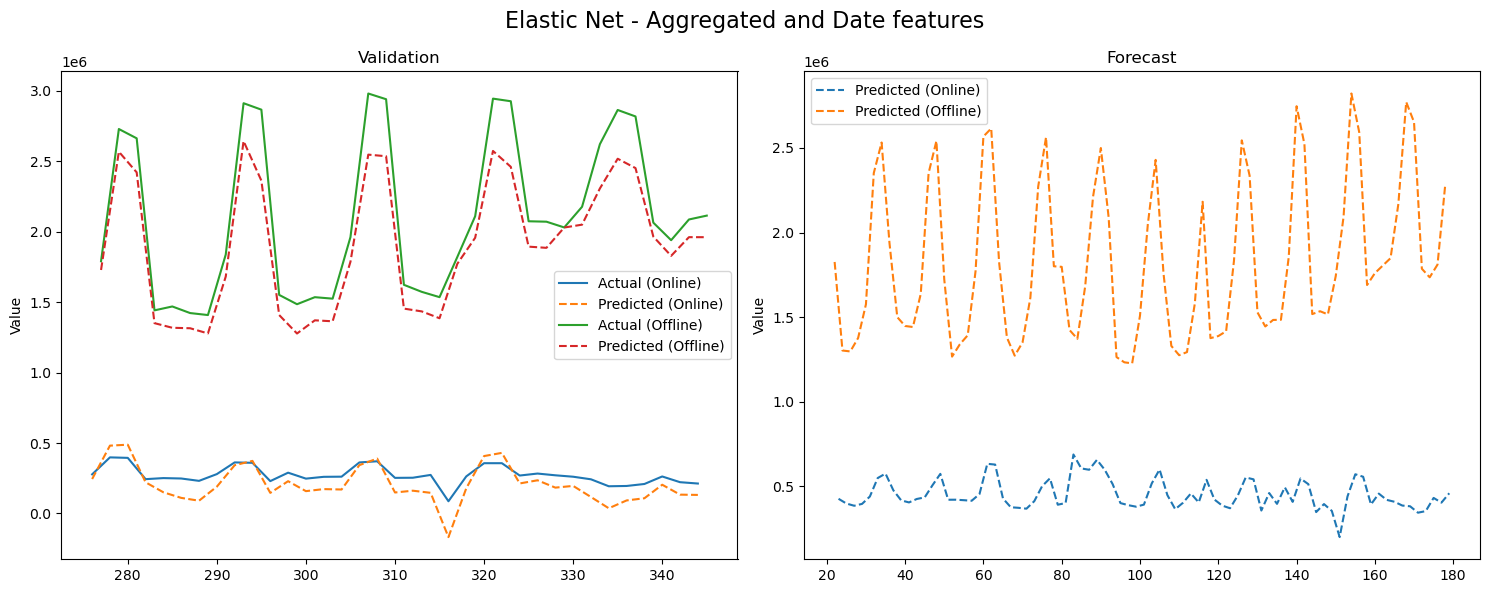

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10


In [ ]:
result_df = predElasticNet(train_X, train_y, online_val_X, online_val_y, offline_val_X, offline_val_y, online_test_X, offline_test_X, 0.1, 0.1, False, result_df,"Elastic Net - Aggregated and Date features")

result_df

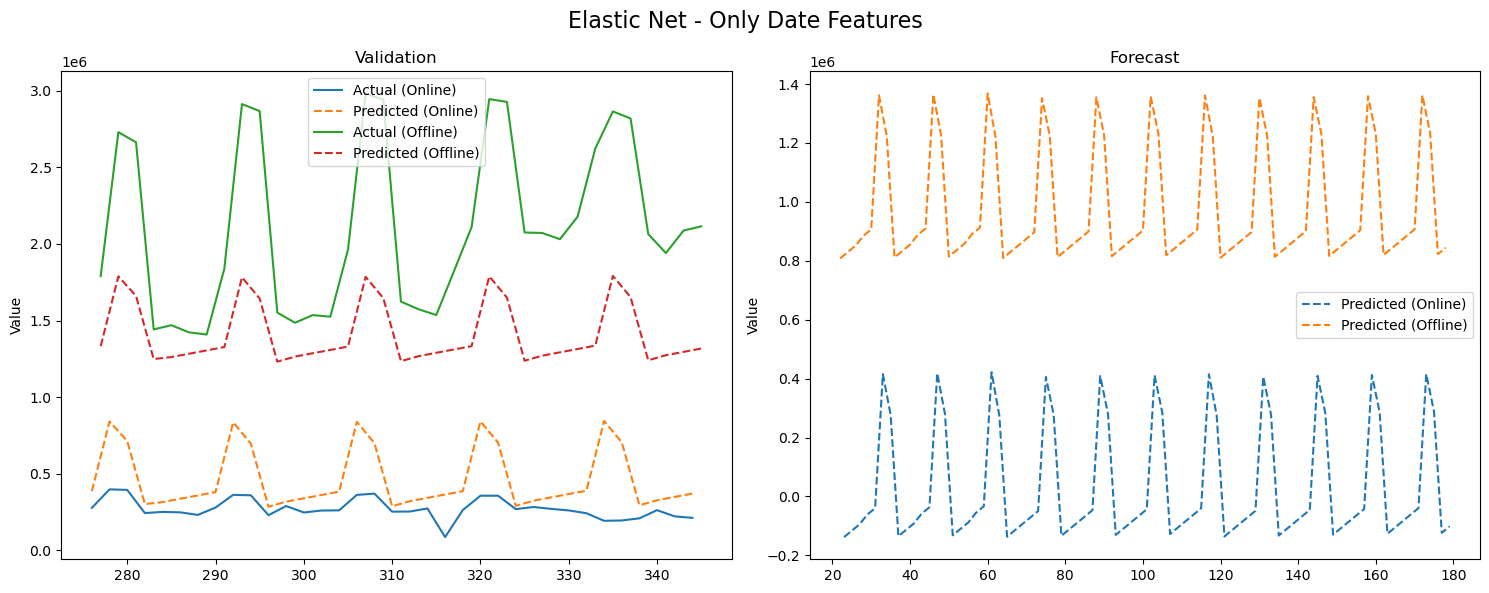

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11


In [ ]:
result_df = predElasticNet(date_train_X, train_y, date_online_val_X, online_val_y, date_offline_val_X, offline_val_y, date_online_test_X, date_offline_test_X,  0.1, 0.1, False, result_df, "Elastic Net - Only Date Features")

result_df

##### Conclusion for Aggregation and Date Features vs Only Date Features
- Both RMSE and capturing seasonality trends are better for the dataset with both aggregation and date features.

#### **9. Model Selection**

In this segment, the focus will be:
- Selecting the best model
    - Elastic net model with fixed alpha=0.1 and l1=0.1 has already been used in previous segment.
    - XHBoost with maxdepth=6 and subsample=1.
    - LSTM with dropout rate=0.2.
        - Due to poor result, there is an additional attempt of using scaled data

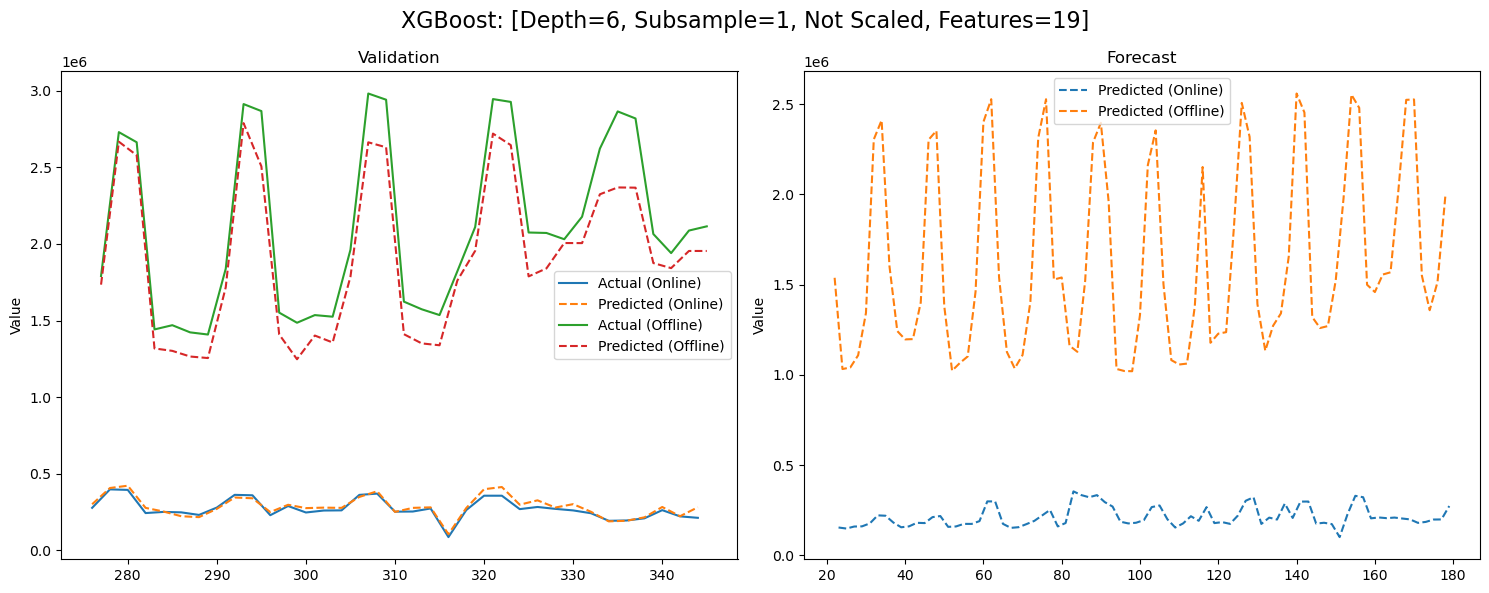

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10


In [ ]:
result_df = predXGBoost(train_X, train_y, online_val_X, online_val_y, offline_val_X, offline_val_y, online_test_X, offline_test_X, 6, 1, False, result_df,"XGBoost: [Depth=6, Subsample=1, Not Scaled, Features=19]")

result_df

Epoch 1/100
9/9 [==============================] - 3s 3ms/step - loss: 1313966522368.0000 - rmse: 1135257.6250
Epoch 2/100
9/9 [==============================] - 0s 3ms/step - loss: 1313966391296.0000 - rmse: 1142807.1250
Epoch 3/100
9/9 [==============================] - 0s 3ms/step - loss: 1313966391296.0000 - rmse: 1132170.5000
Epoch 4/100
9/9 [==============================] - 0s 3ms/step - loss: 1313966129152.0000 - rmse: 1131380.7500
Epoch 5/100
9/9 [==============================] - 0s 3ms/step - loss: 1313965998080.0000 - rmse: 1148165.6250
Epoch 6/100
9/9 [==============================] - 0s 3ms/step - loss: 1313965867008.0000 - rmse: 1149044.6250
Epoch 7/100
9/9 [==============================] - 0s 3ms/step - loss: 1313965604864.0000 - rmse: 1142023.3750
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 1313965604864.0000 - rmse: 1126956.8750
Epoch 9/100
9/9 [==============================] - 0s 3ms/step - loss: 1313965211648.0000 - rmse: 1147461.2500
E

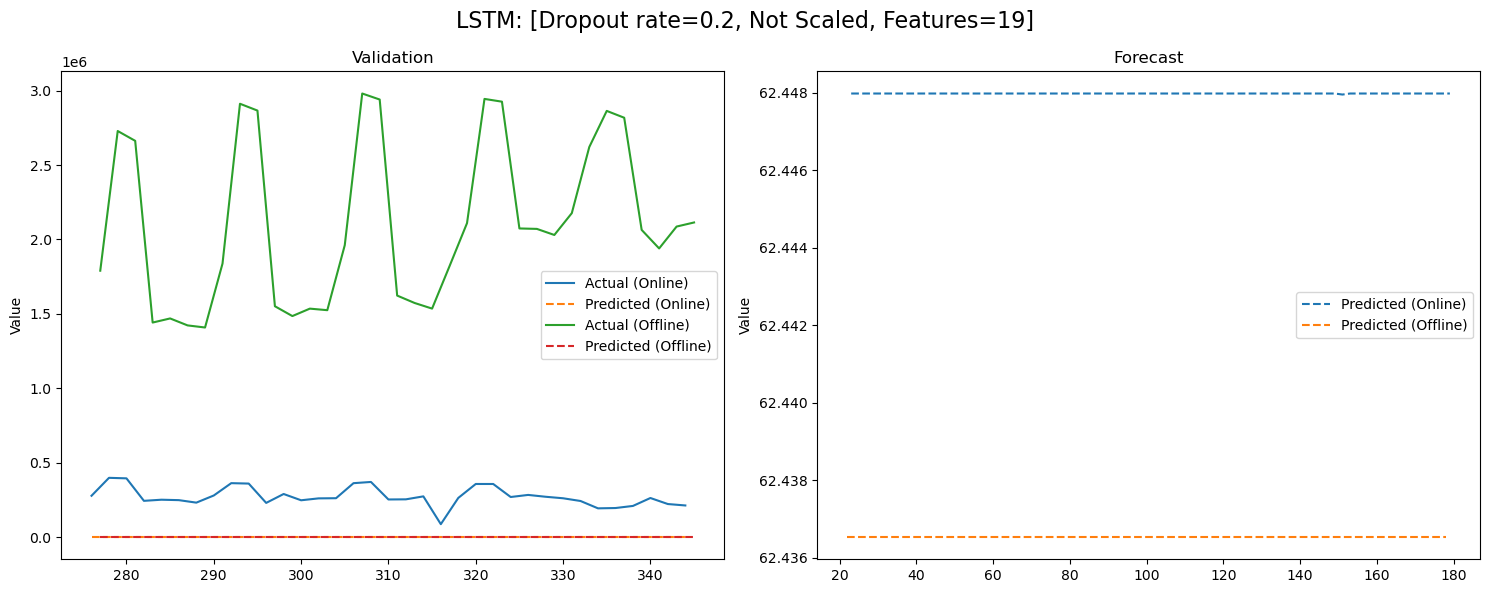

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06


In [ ]:
result_df = predLSTM(train_X, train_y, online_val_X, online_val_y, offline_val_X, offline_val_y, online_test_X, offline_test_X, 0.2, False, result_df,"LSTM: [Dropout rate=0.2, Not Scaled, Features=19]")
result_df

Epoch 1/100
9/9 [==============================] - 3s 2ms/step - loss: 1313965867008.0000 - rmse: 1150105.5000
Epoch 2/100
9/9 [==============================] - 0s 2ms/step - loss: 1313965211648.0000 - rmse: 1140330.8750
Epoch 3/100
9/9 [==============================] - 0s 2ms/step - loss: 1313963900928.0000 - rmse: 1144590.5000
Epoch 4/100
9/9 [==============================] - 0s 2ms/step - loss: 1313961541632.0000 - rmse: 1143354.7500
Epoch 5/100
9/9 [==============================] - 0s 2ms/step - loss: 1313958002688.0000 - rmse: 1136521.7500
Epoch 6/100
9/9 [==============================] - 0s 2ms/step - loss: 1313954332672.0000 - rmse: 1143965.3750
Epoch 7/100
9/9 [==============================] - 0s 2ms/step - loss: 1313949876224.0000 - rmse: 1134143.8750
Epoch 8/100
9/9 [==============================] - 0s 3ms/step - loss: 1313945812992.0000 - rmse: 1133010.1250
Epoch 9/100
9/9 [==============================] - 0s 2ms/step - loss: 1313942142976.0000 - rmse: 1138425.6250
E

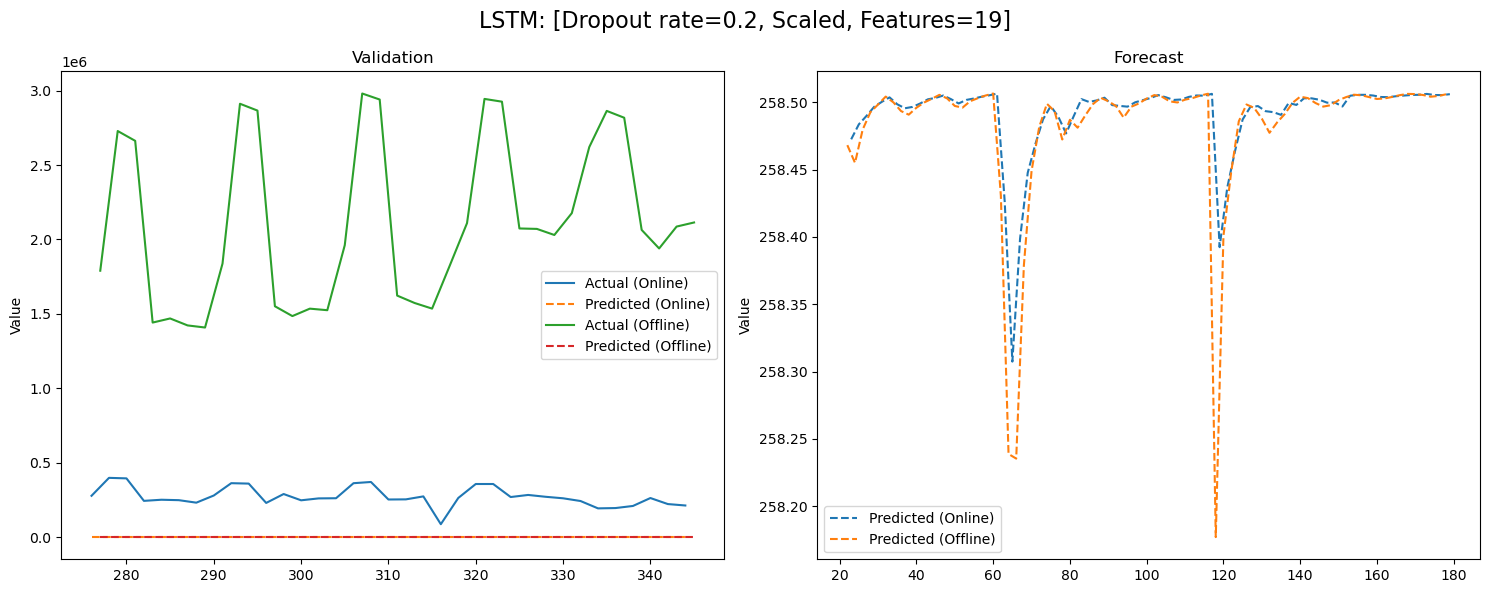

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06


In [ ]:
result_df = predLSTM(scaled_train_X, train_y, scaled_online_val_X, online_val_y, scaled_offline_val_X, offline_val_y, scaled_online_test_X, scaled_offline_test_X,  0.2, True, result_df, "LSTM: [Dropout rate=0.2, Scaled, Features=19]")
result_df

##### Conclusion for model selection:
- While LSTM got the lowest RMSE, it is unable to capture the seasonality trends for the forecast, hence difficult to derive any business insights.
    - An attempt to use scaled data, helped to provide variation to forecast but it was far from the trends that have been seen.
- XGBoost have a lower RMSE than Elastic Net and is able to capture the seasonality effect well.
- Proceed to do hyperparameter tuning for XGBoost.

#### **10. Hyperparameter Tuning**

In this segment, the focus will be:
- Tuning the hyperparameters for XGBoost:
     - Scaled vs Non Scaled
     - Model Parameter
        - MaxDepth = 6,5,4
        - Subsample = 1,0.9
    - Feature Selection
        - Top 5, 10, 15 or all 19 features

##### 1.j.i. Scaled vs Non Scaled

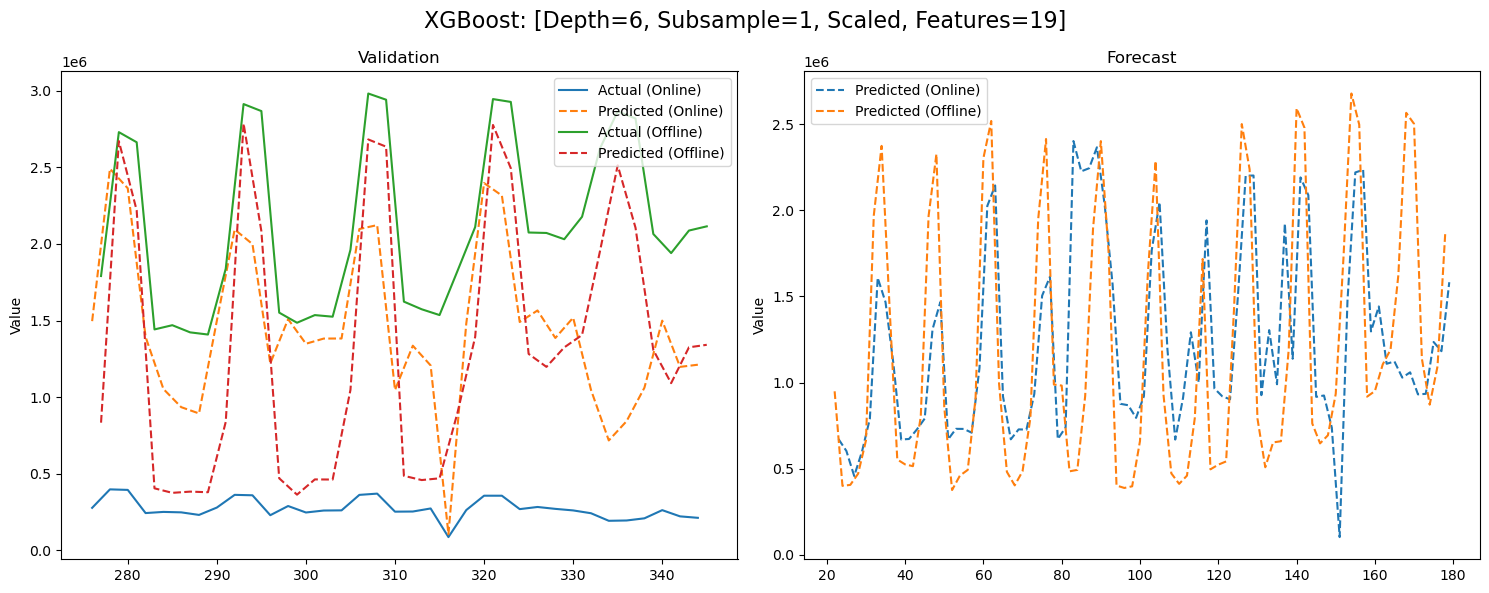

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12


In [ ]:
result_df = predXGBoost(scaled_train_X, train_y, scaled_online_val_X, online_val_y, scaled_offline_val_X, offline_val_y, scaled_online_test_X, scaled_offline_test_X, 6, 1, True, result_df,"XGBoost: [Depth=6, Subsample=1, Scaled, Features=19]")

result_df

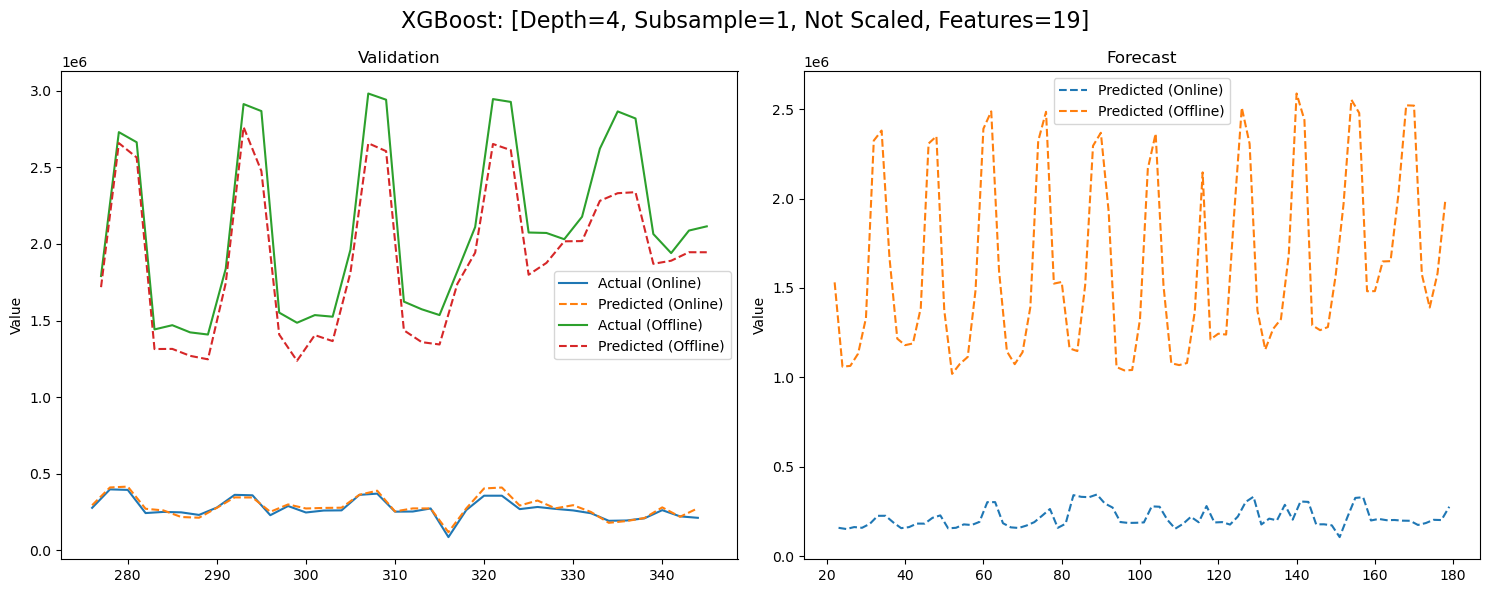

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12
6,XGBoost,0,max_depth=4,subsample=1,19,2.680927e+10


In [ ]:
result_df = predXGBoost(train_X, train_y, online_val_X, online_val_y, offline_val_X, offline_val_y, online_test_X, offline_test_X, 4, 1, False, result_df,"XGBoost: [Depth=4, Subsample=1, Not Scaled, Features=19]")

result_df

##### 2.j.ii.a. Max Depth = [6,5,4]

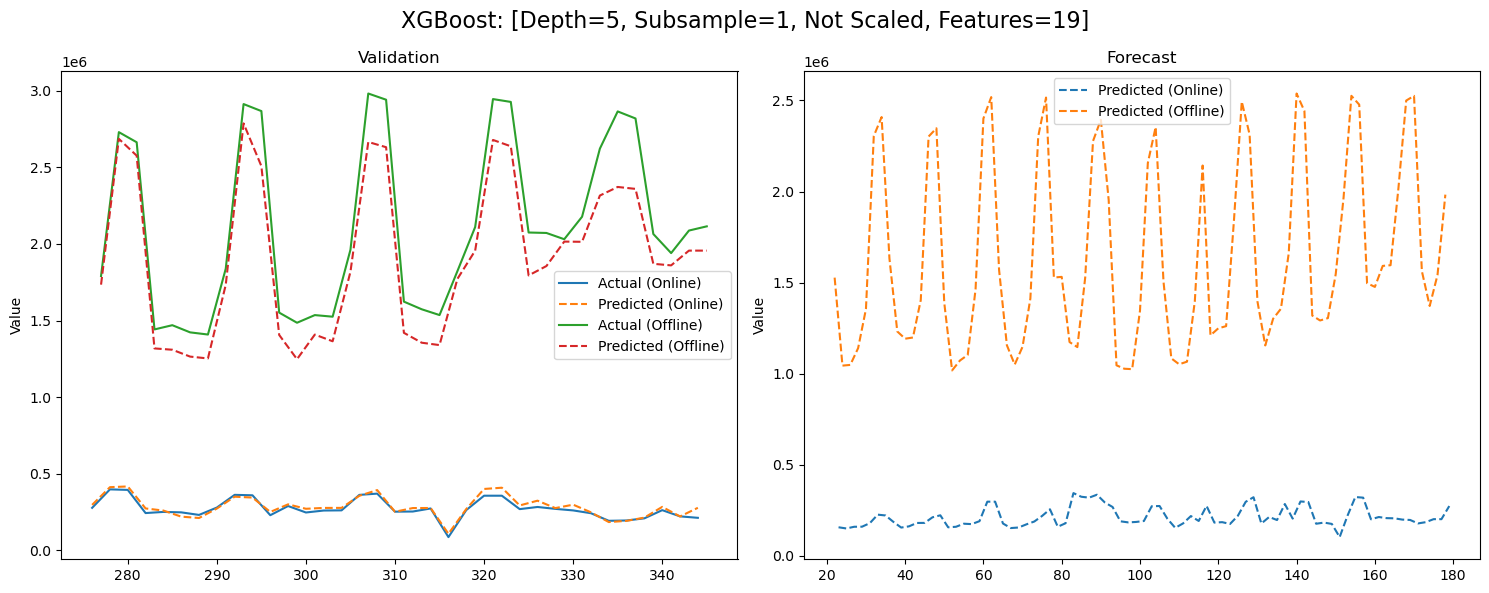

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12
6,XGBoost,0,max_depth=4,subsample=1,19,2.680927e+10
7,XGBoost,0,max_depth=5,subsample=1,19,2.442441e+10


In [ ]:
result_df = predXGBoost(train_X, train_y, online_val_X, online_val_y, offline_val_X, offline_val_y, online_test_X, offline_test_X, 5, 1, False, result_df,"XGBoost: [Depth=5, Subsample=1, Not Scaled, Features=19]")

result_df

##### 2.j.ii.a. Subsample = [1,0.9]

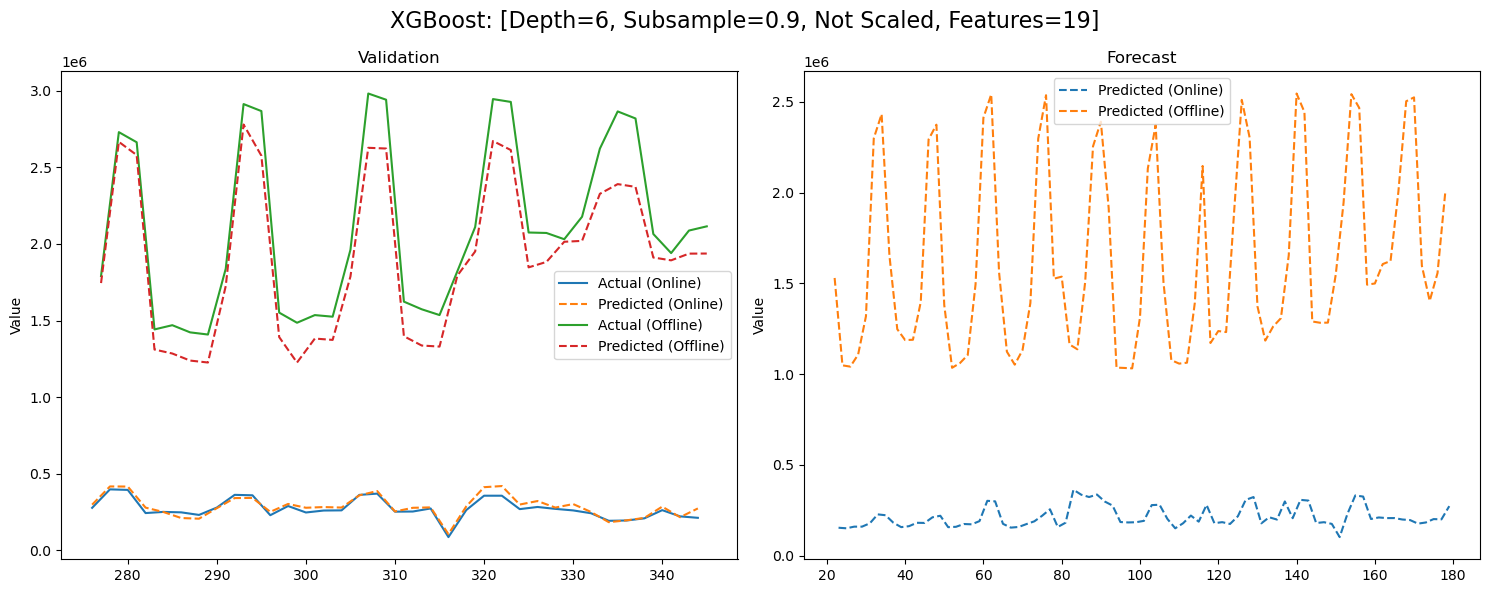

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12
6,XGBoost,0,max_depth=4,subsample=1,19,2.680927e+10
7,XGBoost,0,max_depth=5,subsample=1,19,2.442441e+10
8,XGBoost,0,max_depth=5,subsample=0.9,19,2.457794e+10


In [ ]:
result_df = predXGBoost(train_X, train_y, online_val_X, online_val_y, offline_val_X, offline_val_y, online_test_X, offline_test_X, 5, 0.9, False, result_df,"XGBoost: [Depth=6, Subsample=0.9, Not Scaled, Features=19]")

result_df

##### 2.j.iii. Feature Selection

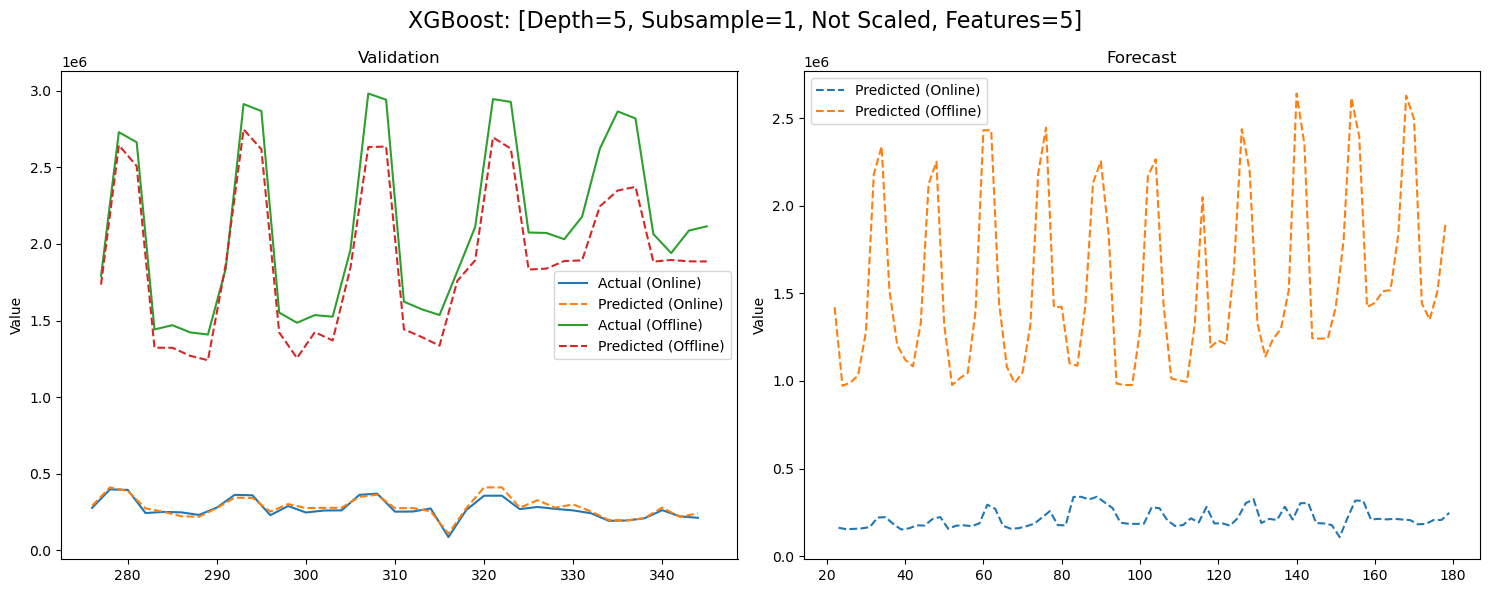

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12
6,XGBoost,0,max_depth=4,subsample=1,19,2.680927e+10
7,XGBoost,0,max_depth=5,subsample=1,19,2.442441e+10
8,XGBoost,0,max_depth=5,subsample=0.9,19,2.457794e+10
9,XGBoost,0,max_depth=5,subsample=1,5,2.608196e+10


In [ ]:
result_df = predXGBoost(top5_train_X, train_y, top5_online_val_X, online_val_y, top5_offline_val_X, offline_val_y, top5_online_test_X, top5_offline_test_X, 5, 1, False, result_df,"XGBoost: [Depth=5, Subsample=1, Not Scaled, Features=5]")

result_df

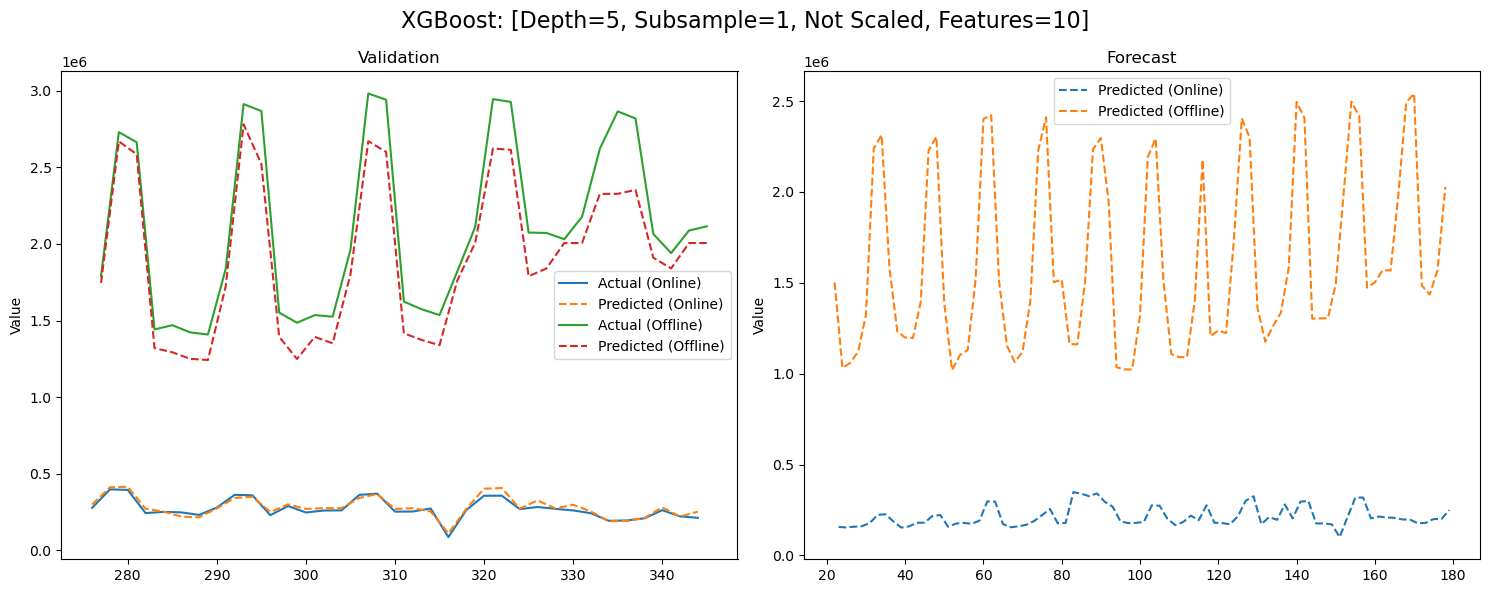

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12
6,XGBoost,0,max_depth=4,subsample=1,19,2.680927e+10
7,XGBoost,0,max_depth=5,subsample=1,19,2.442441e+10
8,XGBoost,0,max_depth=5,subsample=0.9,19,2.457794e+10
9,XGBoost,0,max_depth=5,subsample=1,5,2.608196e+10


In [ ]:
result_df = predXGBoost(top10_train_X, train_y, top10_online_val_X, online_val_y, top10_offline_val_X, offline_val_y, top10_online_test_X, top10_offline_test_X, 5, 1, False, result_df,"XGBoost: [Depth=5, Subsample=1, Not Scaled, Features=10]")

result_df

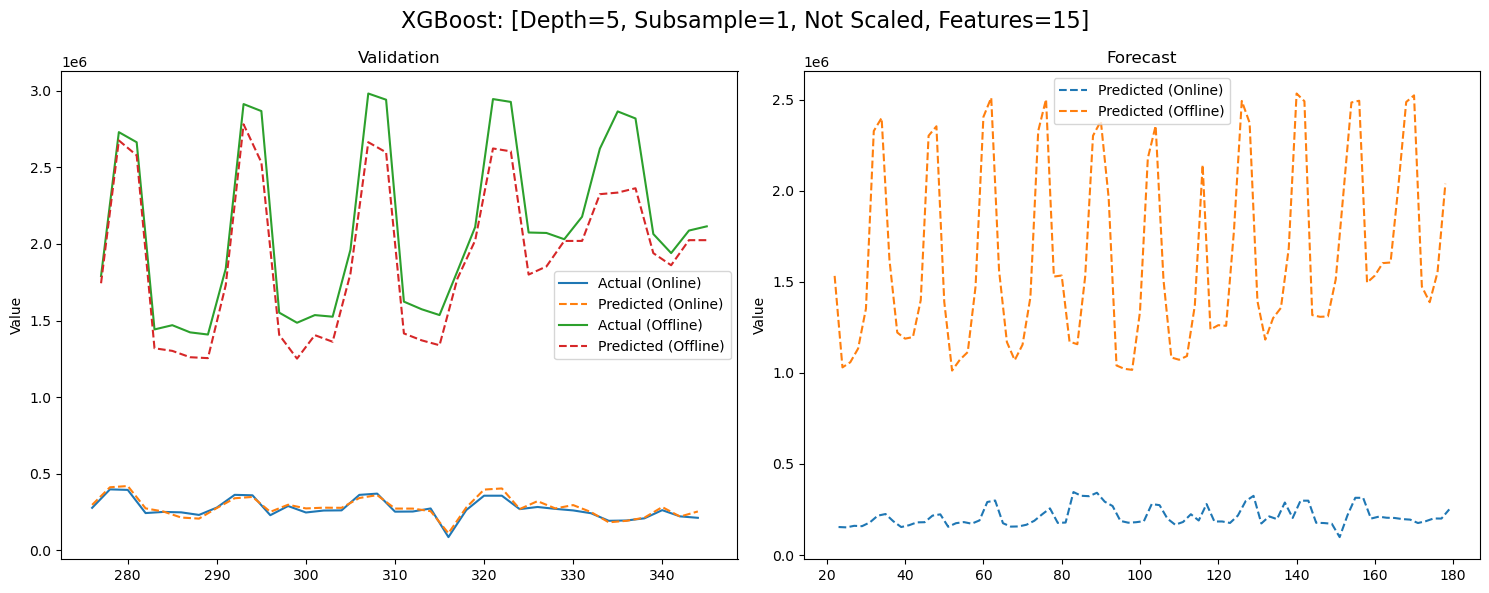

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12
6,XGBoost,0,max_depth=4,subsample=1,19,2.680927e+10
7,XGBoost,0,max_depth=5,subsample=1,19,2.442441e+10
8,XGBoost,0,max_depth=5,subsample=0.9,19,2.457794e+10
9,XGBoost,0,max_depth=5,subsample=1,5,2.608196e+10


In [ ]:
result_df = predXGBoost(top15_train_X, train_y, top15_online_val_X, online_val_y, top15_offline_val_X, offline_val_y, top15_online_test_X, top15_offline_test_X, 5, 1, False, result_df,"XGBoost: [Depth=5, Subsample=1, Not Scaled, Features=15]")

result_df

##### Conclusion for Hyperparameter Tuning:

- Scaling
    - Scaled data normalizes the online and offline data, which mixes up both forecasted data, hence poor RMSE and bad at capturing seasonality trends.
- Model Parameters Tuning
    - All are able to capture seasonality trends to a similar extend hence picked the combination of lowest RMSE.
    - Best parameters: MaxDepth = 5 and Subsample = 1
- Feature Selection:
    - All are able to capture seasonality trends to a similar extend hence picked the combination of lowest RMSE.
    - All 19 features have lowest RMSE, hence no feature selection was needed.

#### **11. Final Model: XGBoost**
- MaxDepth = 5
- Subsample = 1
- Not scaled
- No feature selection

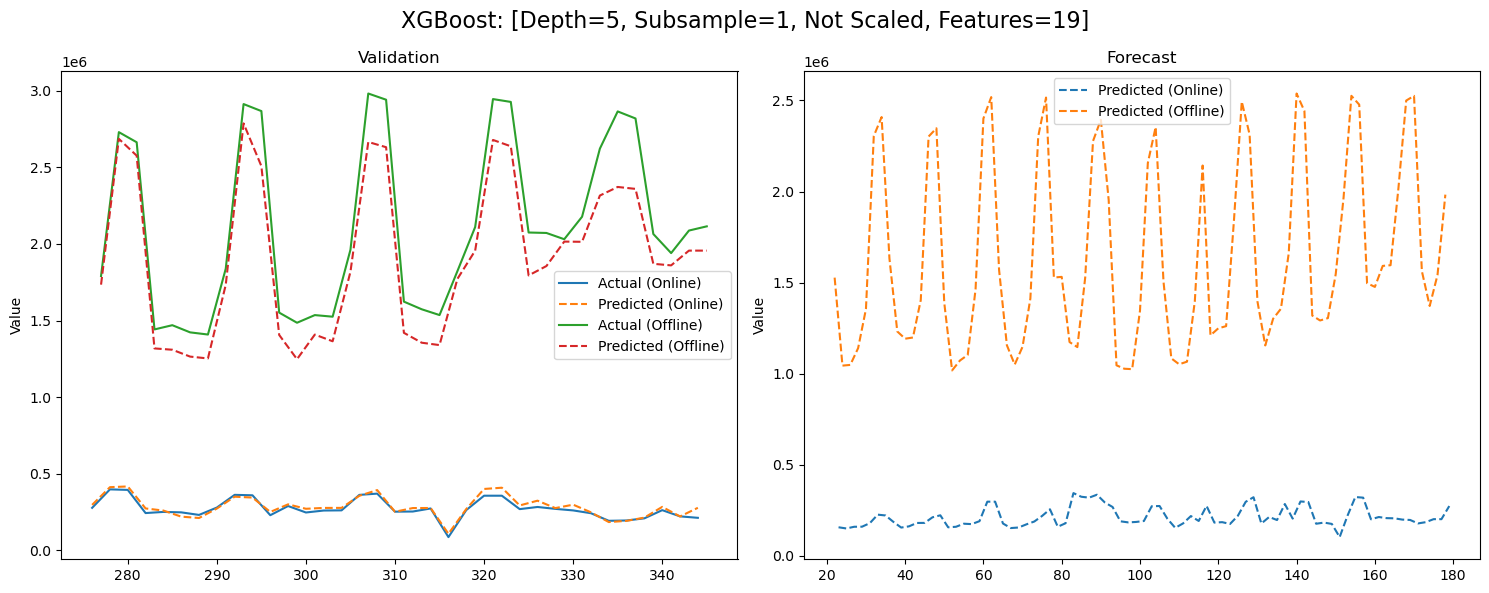

,model,scaled,hyperparameter1,hyperparameter2,number of features,rmse
0,elastic net,0,alpha=0.1,l1_ratio=0.1,19,3.237788e+10
1,elastic net,0,alpha=0.1,l1_ratio=0.1,8,3.517245e+11
2,XGBoost,0,max_depth=6,subsample=1,19,2.463987e+10
3,LSTM,0,dropout=0.2,Null,19,1.189721e+06
4,LSTM,1,dropout=0.2,Null,19,1.189528e+06
5,XGBoost,1,max_depth=6,subsample=1,19,1.140855e+12
6,XGBoost,0,max_depth=4,subsample=1,19,2.680927e+10
7,XGBoost,0,max_depth=5,subsample=1,19,2.442441e+10
8,XGBoost,0,max_depth=5,subsample=0.9,19,2.457794e+10
9,XGBoost,0,max_depth=5,subsample=1,5,2.608196e+10


In [ ]:
predXGBoost(train_X, train_y, online_val_X, online_val_y, offline_val_X, offline_val_y, online_test_X, offline_test_X, 5, 1, False, result_df,"XGBoost: [Depth=5, Subsample=1, Not Scaled, Features=19]")

#### **12. Limitations and Caveat**

1. Model selection and hyperparameter tuning followed a greedy approach, where each model/parameter combination was tried once. If the root mean squared error (RMSE) was higher, not all permutations were tested. Nevertheless, it is practically unlikely that a better model exists.

2. For forecasting, the aggregated data was based on the mean of the same month of quarter, and day. However, the strong day-of-week effect might not align perfectly, but it still resulted in a relatively low RMSE and effectively captured seasonality patterns.

3. Since only Q3 and Q4 data were available, the increase in sales during the holiday season (December) had an impact on the forecasted data for March, as it showed a rising trend as well. It remains uncertain whether this introduces bias into the forecasts.

#### **Conclusion and Business Insights for Sales Forecasting**

1. Based on the time series forecast results for both online and offline data, it is evident that the online forecast remains relatively low compared to offline sales. This indicates that there is significant potential to grow the online market and capture a larger customer base.
- Decathalon can continue to push for more omnichannel approach, where customers can seamlessly switch between online and offline shopping, can create a cohesive and consistent brand experience, driving customer loyalty and engagement.
- Enhancing the online shopping experience, such as implementing user-friendly interfaces, streamlining the checkout process, and offering personalized recommendations, can significantly boost online sales and customer retention.

2. The forecasted data trends remain similar, it indicates a stable and predictable market environment. The consistency in trends provides valuable insights for the business to make informed decisions and capitalize on existing opportunities.
- With stable trends, the business can focus on targeted marketing strategies that have proven to be effective in the past. This allows for better utilization of marketing budgets and a higher return on investment.
- Stable trends enable the business to optimize its supply chain and inventory management. By accurately forecasting demand, the company can avoid stockouts and overstock situations, leading to cost savings and better customer satisfaction.